In [53]:
import importlib
from __imports__ import *
import data, LSTM_returns, optimization
importlib.reload(data)

<module 'data' from 'c:\\Users\\27904\\OneDrive\\桌面\\crypto\\AAA_Thursday1\\data\\__init__.py'>

In [54]:
df = data.load_asset('XRPUSDT', sampling='1d')
df = data.add_fear_and_greed(df)
# Restrict data after 2022
df = df[df.index >= '2022-01-01']
df.head()

,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,F&G,F&G category
Open time,,,,,,,,,,,
2022-01-01,0.8298,0.8557,0.8297,0.8507,136976730.0,1.155075e+08,178238,70090109.0,5.911341e+07,21.0,Extreme Fear
2022-01-02,0.8508,0.8667,0.8372,0.8586,129688032.0,1.102656e+08,176940,65996017.0,5.611762e+07,29.0,Fear
2022-01-03,0.8586,0.8587,0.8213,0.8324,178618617.0,1.498761e+08,232484,89735857.0,7.529882e+07,29.0,Fear
2022-01-04,0.8324,0.8456,0.7794,0.8228,214415744.0,1.776919e+08,270966,104076850.0,8.636767e+07,23.0,Extreme Fear
2022-01-05,0.8227,0.8372,0.7092,0.7726,370612510.0,2.947838e+08,482373,173152247.0,1.379976e+08,24.0,Extreme Fear


In [55]:
import ta  # technical analysis library

look_back = 14

# Return: Daily log return
df['Return'] = np.log(df['Close'] / df['Close'].shift(1))

# Risk: Rolling standard deviation of returns (volatility)
df['Risk'] = df['Return'].rolling(window=look_back).std()

# RSI: Relative Strength Index
df['RSI'] = ta.momentum.RSIIndicator(close=df['Close'], window=look_back).rsi()

# ADX: Average Directional Index
df['ADX'] = ta.trend.ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=look_back).adx()

# MOM: Momentum indicator (difference between close and n periods ago)
df['MOM'] = df['Close'] - df['Close'].shift(look_back)

# HL: High-Low spread (volatility proxy)
df['HL'] = df['High'] - df['Low']

# HO: High-Open gap
df['HO'] = df['High'] - df['Open']

# LO: Low-Open gap
df['LO'] = df['Low'] - df['Open']

df['buy_pressure_ratio'] = df['Taker buy quote asset volume'] / df['Quote asset volume']
df['trades_per_volume'] = df['Number of trades'] / df['Quote asset volume']

def compute_slope(series):
    y = series.values
    x = np.arange(len(y))
    if len(y) == 0:
        return np.nan
    slope = np.polyfit(x, y, 1)[0]
    return slope

# Assume df['Close'] already exists
df['slope'] = df['Close'].rolling(window=look_back).apply(compute_slope, raw=False)

df['MA_7'] = df['Close'].rolling(window=7).mean()

df['MA_14'] = df['Close'].rolling(window=14).mean()


# Drop rows with NaN due to indicator lookback
df = df.dropna()

# Show result
print(df[['Return', 'Risk', 'RSI', 'ADX', 'MOM', 'HL', 'HO', 'LO','MA_7','MA_14']].head())

              Return      Risk        RSI  ADX     MOM      HL      HO  \
Open time                                                                
2022-01-15  0.007602  0.028617  41.775186  0.0 -0.0716  0.0220  0.0167   
2022-01-16 -0.000899  0.028321  41.580959  0.0 -0.0802  0.0204  0.0093   
2022-01-17 -0.021688  0.027819  37.144019  0.0 -0.0707  0.0307  0.0020   
2022-01-18 -0.014280  0.027867  34.574583  0.0 -0.0719  0.0334  0.0070   
2022-01-19 -0.017193  0.022999  31.769592  0.0 -0.0345  0.0302  0.0023   

                LO      MA_7     MA_14  
Open time                               
2022-01-15 -0.0053  0.768886  0.782593  
2022-01-16 -0.0111  0.772514  0.776864  
2022-01-17 -0.0287  0.775629  0.771814  
2022-01-18 -0.0264  0.772857  0.766679  
2022-01-19 -0.0279  0.764200  0.764214  


In [56]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Quote asset volume',
       'Number of trades', 'Taker buy base asset volume',
       'Taker buy quote asset volume', 'F&G', 'F&G category', 'Return', 'Risk',
       'RSI', 'ADX', 'MOM', 'HL', 'HO', 'LO', 'buy_pressure_ratio',
       'trades_per_volume', 'slope', 'MA_7', 'MA_14'],
      dtype='object')

In [57]:
cols_to_drop = ['Open', 'High', 'Low', 'Quote asset volume',
       'Number of trades', 'Taker buy base asset volume',
       'Taker buy quote asset volume','F&G', ]  # add more columns if needed

df = df.drop(columns=cols_to_drop)

In [58]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

In [59]:
# for next-day close price:
df['target_close'] = df['Close'].shift(-1)

# or for next-day return:
df['target_ret'] = df['Return'].shift(-1)

# drop the last row (it has no next-day value)
df = df.dropna(subset = ['target_ret'])   # or ['target_ret']

df = pd.get_dummies(df, columns=['F&G category'], prefix='FG_cat')

In [60]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# pick your shifted target:
target_col = 'target_ret'    # or 'target_ret'

# redefine your features list to include the new dummy columns
features = [
    'Close', 'Volume', 'Return', 'Risk', 'RSI', 'ADX', 'MOM', 'HL',
    'HO', 'LO', 'buy_pressure_ratio', 'trades_per_volume', 'slope'
] + [c for c in df.columns if c.startswith('FG_cat_')]

X = df[features]
y = df[target_col]

# train/test split (no stratify for regression)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# instantiate a regressor
model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)

# evaluate
preds = model.predict(X_test)
mse  = mean_squared_error(y_test, preds)    # default returns MSE
rmse = np.sqrt(mse)                         # now you have RMSE

print("Test RMSE:", rmse)

Test RMSE: 0.043955592853353515


In [61]:
imp = model.get_booster().get_score(importance_type='gain')
imp_df = (
    pd.DataFrame({'feature':list(imp.keys()), 'gain':list(imp.values())})
    .sort_values('gain', ascending=False)
)
print(imp_df.head(100))


                 feature      gain
3                   Risk  0.004966
6                    MOM  0.004846
1                 Volume  0.004844
13   FG_cat_Extreme Fear  0.004720
2                 Return  0.004558
10    buy_pressure_ratio  0.004268
11     trades_per_volume  0.004265
12                 slope  0.004067
14  FG_cat_Extreme Greed  0.004016
4                    RSI  0.003936
7                     HL  0.003900
8                     HO  0.003895
0                  Close  0.003895
5                    ADX  0.003755
9                     LO  0.003272
16          FG_cat_Greed  0.002635
15           FG_cat_Fear  0.002415
17        FG_cat_Neutral  0.001635


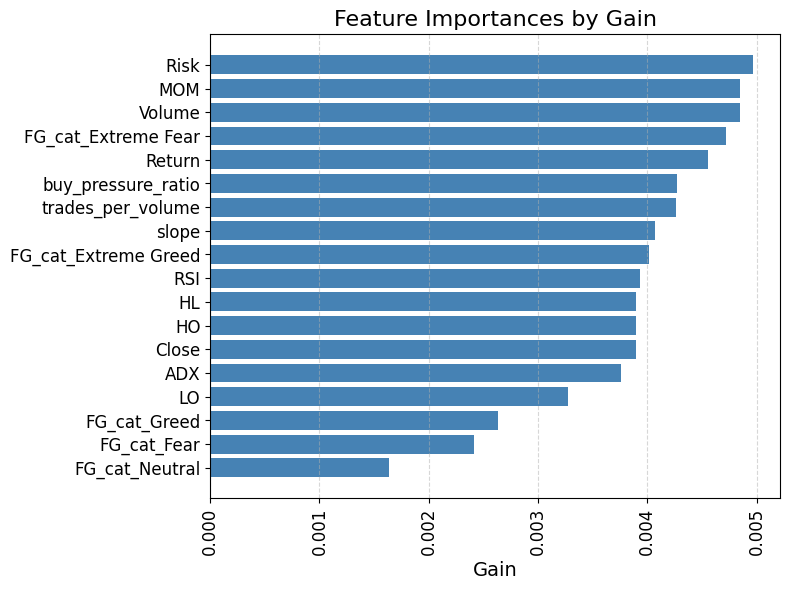

In [62]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Recompute importances from your XGBoost model
imp = model.get_booster().get_score(importance_type='gain')
imp_df = (pd.DataFrame({
            'feature': list(imp.keys()),
            'gain':    list(imp.values())
          })
          .sort_values('gain', ascending=False)
          .reset_index(drop=True)
)

# 2) Horizontal bar chart with a more visible X‐axis
plt.figure(figsize=(8, 6))
plt.barh(imp_df['feature'], imp_df['gain'], color='steelblue')
plt.gca().invert_yaxis()

# Increase font sizes and add grid on X
plt.xlabel('Gain', fontsize=14)
plt.title('Feature Importances by Gain', fontsize=16)
plt.xticks(fontsize=12, rotation='vertical')
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()



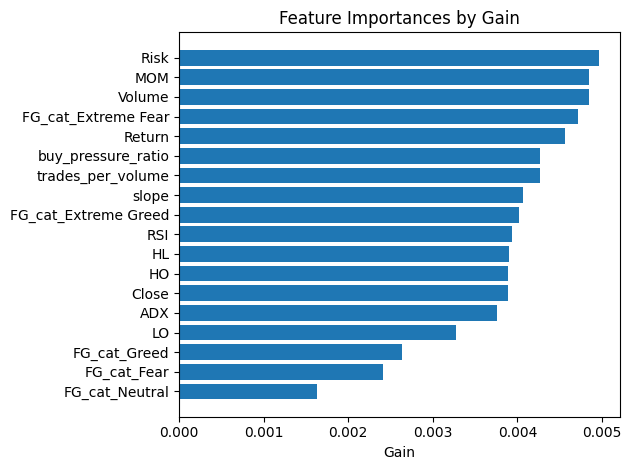

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Recompute importances from your XGBoost model
imp = model.get_booster().get_score(importance_type='gain')
imp_df = pd.DataFrame({
    'feature': list(imp.keys()),
    'gain':    list(imp.values())
}).sort_values('gain', ascending=False).reset_index(drop=True)

# 2) Horizontal bar chart of feature importances
plt.figure()
plt.barh(imp_df['feature'], imp_df['gain'])
plt.xlabel('Gain')
plt.title('Feature Importances by Gain')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

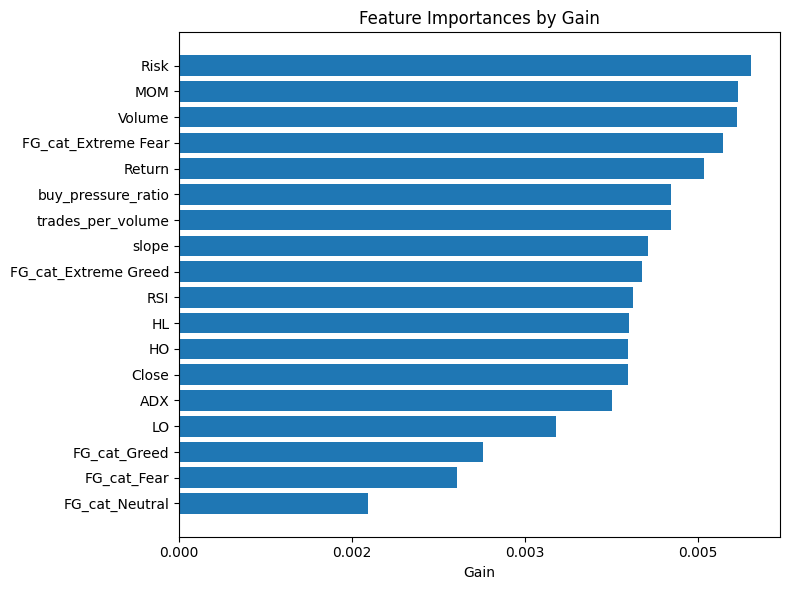

In [64]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd

# Rebuild imp_df if needed
imp = model.get_booster().get_score(importance_type='gain')
imp_df = (
    pd.DataFrame({'feature': list(imp.keys()), 'gain': list(imp.values())})
      .sort_values('gain', ascending=False)
      .reset_index(drop=True)
)

fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(imp_df['feature'], imp_df['gain'])
ax.invert_yaxis()

# 1) Fewer ticks on x-axis
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))

# 2) Fewer decimals (or use scientific notation)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x:.3f}"))

ax.set_xlabel('Gain')
ax.set_title('Feature Importances by Gain')
plt.tight_layout()
plt.show()

In [65]:
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder

# Merge F&G category into 3 classes
def map_fg_category(cat):
    if cat in ['Extreme Fear', 'Fear']:
        return 'Bearish'
    elif cat in ['Greed', 'Extreme Greed']:
        return 'Bullish'
    else:
        return 'Neutral'

df['F&G category merged'] = df['F&G category'].apply(map_fg_category)
le = LabelEncoder()
df['target'] = le.fit_transform(df['F&G category merged'])
#df['target'] = le.fit_transform(df['F&G category'])

# Define features and target
features = [
    'Volume', 'Return', 'Risk', 'RSI', 'ADX', 'MOM', 'HL',
    'HO', 'LO', 'buy_pressure_ratio', 'trades_per_volume', 'slope'
]
X = df[features]
y = df['target']

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Objective function for Optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 30, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 6),
        'objective': 'multi:softmax',
        'num_class': 3,
        'eval_metric': 'mlogloss',
        'tree_method': 'hist',
        'use_label_encoder': False
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    preds = model.predict(X_val)
    return f1_score(y_val, preds, average='macro')

# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)

# Best parameters and final model
best_params = study.best_params
best_params.update({
    'objective': 'multi:softmax',
    'num_class': 3,
    'eval_metric': 'mlogloss',
    'tree_method': 'hist',
    'use_label_encoder': False
})
final_model = xgb.XGBClassifier(**best_params)
final_model.fit(X_train, y_train)

# Final evaluation
y_pred = final_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred, target_names=le.classes_)

# Feature importance
booster = final_model.get_booster()
importance_gain = booster.get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': list(importance_gain.keys()),
    'Importance (Gain)': list(importance_gain.values())
}).sort_values(by='Importance (Gain)', ascending=False)

accuracy, report, importance_df.head(10)


KeyError: 'F&G category'